In [113]:
import random
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn 
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import * 

import warnings
warnings.filterwarnings("ignore")

In [114]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42) # Seed 고정

In [115]:
def RUL_metric(y_valid, y_pred, threshold=10):

    error = y_valid.reshape(-1) - y_pred.reshape(-1)
    per = np.where(error<=threshold, 1, 0)
    
    return sum(per) / len(per)


In [116]:
path = "data/Battery_RUL.csv"

In [117]:
data = pd.read_csv(path)

In [118]:
data.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [119]:
data.shape

(15064, 9)

In [120]:
# 다음 컬럼들은 RUL에 관계가 없기 때문에 제거한다.
data=data.drop(['Cycle_Index','Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Time constant current (s)','Charging time (s)'],axis=1)

In [121]:
data.head()

,Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),RUL
0,3.670,3.211,5460.001,1112
1,4.246,3.220,5508.992,1111
2,4.249,3.224,5508.993,1110
3,4.250,3.225,5502.016,1109
4,4.290,3.398,5480.992,1107


## Modeling and Predections

In [122]:
class Pipeline:
    def __init__(self, scalar):
        self.scalar = scalar
    
    def fit(self, X, y):
        X = self.scalar.fit_transform(X)
        return X, y.to_numpy(dtype=np.float32)
    
    def transform(self, X, y):
        X = self.scalar.transform(X)
        return X, y.to_numpy(dtype=np.float32)

In [123]:
data = data[data['RUL']!=0]

X = data.drop(['RUL'], axis=1)
y = data['RUL']

In [124]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle =False)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, shuffle =False)
    

In [125]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
pipeline = Pipeline(scaler)

In [126]:
X_train_s, y_train_s = pipeline.fit(X_train, y_train)
X_val_s, y_val_s = pipeline.transform(X_val, y_val)
X_test_s, y_test_s = pipeline.transform(X_test, y_test)

In [127]:
from torch.utils.data import Dataset, DataLoader

In [128]:
class BatteryDataSet(Dataset):

    def __init__(self, X,y):
        # Data loading
        # self.x = torch.from_numpy(dataset[:, :-1])
        # self.y = torch.from_numpy(dataset[:, [-1]])
        # self.n_samples = self.x.shape[0]
        self.x = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).unsqueeze(-1)
        self.n_samples = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        # len(Dataset)
        return self.n_samples

In [129]:
train_dataset = BatteryDataSet(X_train_s, y_train_s)
valid_dataset = BatteryDataSet(X_val_s, y_val_s)
test_dataset = BatteryDataSet(X_test_s, y_test_s)

In [130]:
train_indices = list(range(len(train_dataset)))
valid_indices = list(range(len(valid_dataset)))
test_indices = list(range(len(test_dataset)))

In [131]:
from torch.utils.data.sampler import SubsetRandomSampler

In [132]:
batch_size = 32

In [133]:
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

# set valid dataset ot samplers and loader
valid_sampler = SubsetRandomSampler(valid_indices)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)


# set test dataset ot samplers and loader
test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)


In [134]:
X_train_s.shape, y_train_s.shape

((10535, 3), (10535,))

In [135]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [136]:
input_size = X_train_s.shape[1] #num of columns
hidden_size = 16
num_classes = 1

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


In [137]:
from tqdm import tqdm

In [138]:
min_diff_dict = {}

In [139]:
train_loss_list = []

def train_loop(epoch, train_loader, model, loss_fn, optimizer):
    model.train()
    size = len(train_loader)
    train_loss = 0
    with tqdm(train_loader) as pbar :
        for idx, (inputs, y) in enumerate(pbar):
            # Forward path
            outputs = model(inputs)           # ([32, 6])
            loss = loss_fn(outputs, y)

            # Backwards path
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss' : f"{loss.item()/batch_size}"})

    train_loss /= size
    print('===> Epoch [{}] : loss : {:.5}'.format(epoch,  train_loss))
    train_loss_list.append(train_loss)

In [140]:
test_loss_list = []

def val_loop(epoch, dataloader, model, best_model, best_RUL, loss_fn):
    size = len(dataloader)
    test_loss = 0
    targets_list = []
    pred_list = []
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # # Target vs prediction
            pred_np = pred.squeeze().tolist()
            target_np = y.squeeze().tolist()

            try:
                for i,j in zip(pred_np,target_np):
                    pred_list.append(i)
                    targets_list.append(j)
            except:
                pass

    # Average loss
    test_loss /= size
    test_loss_list.append(test_loss)
    scheduler.step(test_loss)
    
    # pred = pred.detach().cpu().numpy()
    # y = y_val_s.detach().cpu().numpy()
    targets_list = np.array(targets_list)
    pred_list = np.array(pred_list)
    RMSE = mean_squared_error(targets_list, pred_list, squared=False)
    MAE = mean_absolute_error(targets_list, pred_list)
    MAPE = mean_absolute_percentage_error(targets_list, pred_list)
    R2 = r2_score(targets_list, pred_list)
    RUL_score = RUL_metric(targets_list, pred_list, threshold=100)
    msg = f"Test: \n Avg loss: {test_loss:>8f}, \n"
    print(msg) 
    msg = f"- RMSE: {(RMSE):>0.2f}, - MAE: {(MAE):>0.2f}, - MAPE: {(MAPE):>0.2f},  - R2: {(R2):>0.2f},  - RUL_metric: {(RUL_score):>0.2f}, \n"
    print(msg)
    print('---'*20)
    
    if RUL_score > best_RUL:
        best_RUL = RUL_score
        best_model = model

    return best_model, best_RUL


In [141]:
epochs = 100

In [142]:
best_model = 0
best_RUL = 0
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    train_loop(epoch, train_loader, model, criterion, optimizer)
    best_model, best_RUL = val_loop(epoch, valid_loader, model, best_model, best_RUL, criterion)


print("Fertig!")


Epoch 1
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 592.24it/s, loss=181.3141326904297] 


===> Epoch [0] : loss : 6.0566e+04
Test: 
 Avg loss: 22261.124214, 

- RMSE: 149.21, - MAE: 108.39, - MAPE: 0.71,  - R2: 0.81,  - RUL_metric: 0.61, 

------------------------------------------------------------
Epoch 2
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 620.66it/s, loss=104.14192962646484]


===> Epoch [1] : loss : 1.2888e+04
Test: 
 Avg loss: 21663.223693, 

- RMSE: 147.20, - MAE: 119.61, - MAPE: 1.00,  - R2: 0.81,  - RUL_metric: 0.59, 

------------------------------------------------------------
Epoch 3
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 629.82it/s, loss=149.32716369628906]


===> Epoch [2] : loss : 1.0845e+04
Test: 
 Avg loss: 17606.353135, 

- RMSE: 132.59, - MAE: 108.29, - MAPE: 1.11,  - R2: 0.85,  - RUL_metric: 0.62, 

------------------------------------------------------------
Epoch 4
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 596.64it/s, loss=40.9658317565918]  


===> Epoch [3] : loss : 9091.1
Test: 
 Avg loss: 18246.605914, 

- RMSE: 135.11, - MAE: 95.69, - MAPE: 1.00,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 5
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 613.15it/s, loss=130.7180938720703] 


===> Epoch [4] : loss : 9172.2
Test: 
 Avg loss: 19692.118942, 

- RMSE: 140.37, - MAE: 97.23, - MAPE: 1.08,  - R2: 0.83,  - RUL_metric: 0.68, 

------------------------------------------------------------
Epoch 6
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 627.17it/s, loss=89.99491119384766] 


===> Epoch [5] : loss : 9369.2
Test: 
 Avg loss: 18992.183883, 

- RMSE: 137.86, - MAE: 98.65, - MAPE: 1.15,  - R2: 0.83,  - RUL_metric: 0.67, 

------------------------------------------------------------
Epoch 7
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 597.20it/s, loss=115.22135925292969]


===> Epoch [6] : loss : 9076.6
Test: 
 Avg loss: 19342.748129, 

- RMSE: 139.12, - MAE: 102.60, - MAPE: 1.23,  - R2: 0.83,  - RUL_metric: 0.70, 

------------------------------------------------------------
Epoch 8
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 627.76it/s, loss=375.96954345703125]


===> Epoch [7] : loss : 8997.1
Test: 
 Avg loss: 19902.315702, 

- RMSE: 141.09, - MAE: 106.96, - MAPE: 1.05,  - R2: 0.83,  - RUL_metric: 0.61, 

------------------------------------------------------------
Epoch 9
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 614.05it/s, loss=276.4062805175781] 


===> Epoch [8] : loss : 9185.6
Test: 
 Avg loss: 18977.374525, 

- RMSE: 137.78, - MAE: 95.75, - MAPE: 0.97,  - R2: 0.83,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 10
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 588.58it/s, loss=54.2021484375]     


===> Epoch [9] : loss : 8755.9
Test: 
 Avg loss: 19250.880298, 

- RMSE: 138.51, - MAE: 97.14, - MAPE: 1.03,  - R2: 0.83,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 11
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 615.86it/s, loss=93.51582336425781] 


===> Epoch [10] : loss : 9369.5
Test: 
 Avg loss: 20893.941337, 

- RMSE: 144.58, - MAE: 101.57, - MAPE: 1.00,  - R2: 0.82,  - RUL_metric: 0.64, 

------------------------------------------------------------
Epoch 12
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 632.22it/s, loss=46.613487243652344]


===> Epoch [11] : loss : 8934.0
Test: 
 Avg loss: 18469.380496, 

- RMSE: 135.94, - MAE: 97.83, - MAPE: 1.10,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 13
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 604.91it/s, loss=223.3163604736328] 


===> Epoch [12] : loss : 8944.9
Test: 
 Avg loss: 19425.726519, 

- RMSE: 139.42, - MAE: 100.64, - MAPE: 1.03,  - R2: 0.83,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 14
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 616.74it/s, loss=46.240234375]      


===> Epoch [13] : loss : 8701.2
Test: 
 Avg loss: 19289.631145, 

- RMSE: 138.90, - MAE: 96.52, - MAPE: 1.06,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 15
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 624.87it/s, loss=218.2372283935547] 


===> Epoch [14] : loss : 8320.8
Test: 
 Avg loss: 18348.128755, 

- RMSE: 135.48, - MAE: 96.88, - MAPE: 1.01,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 16
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 606.45it/s, loss=131.603271484375]  


===> Epoch [15] : loss : 8135.2
Test: 
 Avg loss: 18055.661219, 

- RMSE: 134.36, - MAE: 95.38, - MAPE: 1.06,  - R2: 0.84,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 17
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 621.82it/s, loss=64.16606903076172] 


===> Epoch [16] : loss : 8110.8
Test: 
 Avg loss: 18576.531198, 

- RMSE: 136.34, - MAE: 96.76, - MAPE: 1.05,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 18
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 608.71it/s, loss=245.0198211669922] 


===> Epoch [17] : loss : 8090.5
Test: 
 Avg loss: 18811.074400, 

- RMSE: 137.19, - MAE: 99.65, - MAPE: 1.08,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 19
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 595.60it/s, loss=41.38154983520508] 


===> Epoch [18] : loss : 8074.7
Test: 
 Avg loss: 18666.582217, 

- RMSE: 136.64, - MAE: 98.32, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 20
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 609.91it/s, loss=214.20651245117188]


===> Epoch [19] : loss : 8086.0
Test: 
 Avg loss: 18959.123008, 

- RMSE: 137.71, - MAE: 99.46, - MAPE: 1.08,  - R2: 0.83,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 21
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 639.58it/s, loss=147.69761657714844]


===> Epoch [20] : loss : 8065.4
Test: 
 Avg loss: 18746.652201, 

- RMSE: 136.97, - MAE: 98.17, - MAPE: 1.07,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 22
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 632.56it/s, loss=88.62995147705078] 


===> Epoch [21] : loss : 8071.4
Test: 
 Avg loss: 18713.078125, 

- RMSE: 136.83, - MAE: 98.30, - MAPE: 1.11,  - R2: 0.84,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 23
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 631.99it/s, loss=313.5851135253906] 


===> Epoch [22] : loss : 8080.9
Test: 
 Avg loss: 19000.467225, 

- RMSE: 137.86, - MAE: 99.15, - MAPE: 1.08,  - R2: 0.83,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 24
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 606.80it/s, loss=132.33306884765625]


===> Epoch [23] : loss : 8063.9
Test: 
 Avg loss: 19135.504697, 

- RMSE: 138.31, - MAE: 99.99, - MAPE: 1.10,  - R2: 0.83,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 25
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 646.69it/s, loss=118.24163055419922]


===> Epoch [24] : loss : 8039.9
Test: 
 Avg loss: 18957.686446, 

- RMSE: 137.71, - MAE: 98.94, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 26
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 629.71it/s, loss=85.84678649902344] 


===> Epoch [25] : loss : 7981.7
Test: 
 Avg loss: 18739.657252, 

- RMSE: 136.92, - MAE: 97.58, - MAPE: 1.10,  - R2: 0.84,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 27
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 605.37it/s, loss=88.46537017822266] 


===> Epoch [26] : loss : 7981.5
Test: 
 Avg loss: 18846.178179, 

- RMSE: 137.30, - MAE: 97.99, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 28
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 640.54it/s, loss=644.9368286132812] 


===> Epoch [27] : loss : 8016.6
Test: 
 Avg loss: 18966.409551, 

- RMSE: 137.71, - MAE: 98.52, - MAPE: 1.09,  - R2: 0.83,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 29
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 640.76it/s, loss=97.08194732666016] 


===> Epoch [28] : loss : 7973.6
Test: 
 Avg loss: 18652.360710, 

- RMSE: 136.61, - MAE: 96.89, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 30
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 644.27it/s, loss=139.67698669433594]


===> Epoch [29] : loss : 7980.3
Test: 
 Avg loss: 18737.096209, 

- RMSE: 136.89, - MAE: 97.36, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 31
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 618.05it/s, loss=61.83143997192383] 


===> Epoch [30] : loss : 7972.9
Test: 
 Avg loss: 18837.901406, 

- RMSE: 137.28, - MAE: 97.86, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 32
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 631.32it/s, loss=96.92095184326172] 


===> Epoch [31] : loss : 7973.8
Test: 
 Avg loss: 18674.353870, 

- RMSE: 136.70, - MAE: 97.07, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 33
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 635.99it/s, loss=99.7210464477539]  


===> Epoch [32] : loss : 7972.9
Test: 
 Avg loss: 18661.941631, 

- RMSE: 136.63, - MAE: 96.90, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 34
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 605.34it/s, loss=136.53555297851562]


===> Epoch [33] : loss : 7979.8
Test: 
 Avg loss: 18770.949603, 

- RMSE: 137.04, - MAE: 97.40, - MAPE: 1.08,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 35
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 637.98it/s, loss=34.242164611816406]


===> Epoch [34] : loss : 7968.4
Test: 
 Avg loss: 18841.296620, 

- RMSE: 137.11, - MAE: 97.55, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 36
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 640.53it/s, loss=403.9779968261719] 


===> Epoch [35] : loss : 7996.6
Test: 
 Avg loss: 18837.646463, 

- RMSE: 137.29, - MAE: 97.81, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 37
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 643.02it/s, loss=42.33150863647461] 


===> Epoch [36] : loss : 7960.5
Test: 
 Avg loss: 18822.589390, 

- RMSE: 137.24, - MAE: 97.74, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 38
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 618.11it/s, loss=284.02081298828125]


===> Epoch [37] : loss : 7978.7
Test: 
 Avg loss: 18817.296516, 

- RMSE: 137.21, - MAE: 97.70, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 39
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 641.96it/s, loss=115.8464126586914] 


===> Epoch [38] : loss : 7965.5
Test: 
 Avg loss: 18806.607478, 

- RMSE: 137.16, - MAE: 97.63, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 40
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 639.14it/s, loss=227.45663452148438]


===> Epoch [39] : loss : 7974.0
Test: 
 Avg loss: 18804.107189, 

- RMSE: 137.16, - MAE: 97.63, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 41
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 614.99it/s, loss=389.41595458984375]


===> Epoch [40] : loss : 7986.4
Test: 
 Avg loss: 18800.123194, 

- RMSE: 137.15, - MAE: 97.61, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 42
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 645.53it/s, loss=258.78973388671875]


===> Epoch [41] : loss : 7976.2
Test: 
 Avg loss: 18806.458945, 

- RMSE: 137.15, - MAE: 97.60, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 43
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 653.40it/s, loss=91.500244140625]   


===> Epoch [42] : loss : 7963.4
Test: 
 Avg loss: 18806.074806, 

- RMSE: 137.14, - MAE: 97.59, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 44
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 653.98it/s, loss=207.5028076171875] 


===> Epoch [43] : loss : 7972.1
Test: 
 Avg loss: 18797.947542, 

- RMSE: 137.14, - MAE: 97.60, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 45
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 614.99it/s, loss=153.880126953125]  


===> Epoch [44] : loss : 7968.4
Test: 
 Avg loss: 18792.600137, 

- RMSE: 137.12, - MAE: 97.57, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 46
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 648.79it/s, loss=333.2401428222656] 


===> Epoch [45] : loss : 7981.8
Test: 
 Avg loss: 18813.113424, 

- RMSE: 137.13, - MAE: 97.57, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 47
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 646.73it/s, loss=39.42919921875]    


===> Epoch [46] : loss : 7959.3
Test: 
 Avg loss: 18790.674554, 

- RMSE: 137.12, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 48
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 651.37it/s, loss=199.62802124023438]


===> Epoch [47] : loss : 7970.3
Test: 
 Avg loss: 18810.034124, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 49
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 621.32it/s, loss=89.38743591308594] 


===> Epoch [48] : loss : 7962.0
Test: 
 Avg loss: 18795.868756, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 50
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 652.29it/s, loss=183.14529418945312]


===> Epoch [49] : loss : 7969.1
Test: 
 Avg loss: 18792.755086, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 51
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 647.58it/s, loss=265.2136535644531] 


===> Epoch [50] : loss : 7975.3
Test: 
 Avg loss: 18841.646199, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 52
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 646.80it/s, loss=81.77991485595703] 


===> Epoch [51] : loss : 7961.4
Test: 
 Avg loss: 18793.170898, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 53
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 626.76it/s, loss=24.815462112426758]


===> Epoch [52] : loss : 7957.1
Test: 
 Avg loss: 18796.415519, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 54
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 649.31it/s, loss=136.17047119140625]


===> Epoch [53] : loss : 7965.5
Test: 
 Avg loss: 18797.782520, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 55
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 650.97it/s, loss=126.90518951416016]


===> Epoch [54] : loss : 7964.8
Test: 
 Avg loss: 18841.410787, 

- RMSE: 137.12, - MAE: 97.55, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 56
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 646.12it/s, loss=113.22490692138672]


===> Epoch [55] : loss : 7963.8
Test: 
 Avg loss: 18799.130410, 

- RMSE: 137.13, - MAE: 97.55, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 57
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 598.43it/s, loss=248.85952758789062]


===> Epoch [56] : loss : 7974.0
Test: 
 Avg loss: 18794.177834, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 58
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 633.21it/s, loss=17.077407836914062]


===> Epoch [57] : loss : 7956.5
Test: 
 Avg loss: 18870.556131, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 59
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 634.98it/s, loss=58.72627639770508] 


===> Epoch [58] : loss : 7959.5
Test: 
 Avg loss: 18792.517989, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 60
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 645.32it/s, loss=181.8128204345703] 


===> Epoch [59] : loss : 7968.8
Test: 
 Avg loss: 18795.998323, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 61
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 621.37it/s, loss=222.85208129882812]


===> Epoch [60] : loss : 7971.9
Test: 
 Avg loss: 18799.857880, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 62
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 651.36it/s, loss=196.91786193847656]


===> Epoch [61] : loss : 7970.0
Test: 
 Avg loss: 18791.891839, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 63
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 641.27it/s, loss=204.7731475830078] 


===> Epoch [62] : loss : 7970.6
Test: 
 Avg loss: 18805.269246, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 64
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 646.73it/s, loss=153.96096801757812]


===> Epoch [63] : loss : 7966.7
Test: 
 Avg loss: 18794.259813, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 65
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 620.50it/s, loss=152.5552215576172] 


===> Epoch [64] : loss : 7966.6
Test: 
 Avg loss: 18793.268607, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 66
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 651.68it/s, loss=42.33629608154297] 


===> Epoch [65] : loss : 7958.3
Test: 
 Avg loss: 18802.944937, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 67
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 557.89it/s, loss=235.20870971679688]


===> Epoch [66] : loss : 7972.9
Test: 
 Avg loss: 18818.725158, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 68
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 618.38it/s, loss=80.84566497802734] 


===> Epoch [67] : loss : 7961.2
Test: 
 Avg loss: 18792.948778, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 69
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 619.83it/s, loss=187.56838989257812]


===> Epoch [68] : loss : 7969.3
Test: 
 Avg loss: 18795.197382, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 70
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 588.05it/s, loss=184.30160522460938]


===> Epoch [69] : loss : 7969.0
Test: 
 Avg loss: 18852.566847, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 71
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 625.99it/s, loss=263.2876892089844] 


===> Epoch [70] : loss : 7975.0
Test: 
 Avg loss: 18798.604916, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 72
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 627.18it/s, loss=141.5642547607422] 


===> Epoch [71] : loss : 7965.8
Test: 
 Avg loss: 18798.769687, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 73
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 603.70it/s, loss=99.53946685791016] 


===> Epoch [72] : loss : 7962.6
Test: 
 Avg loss: 18794.720427, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 74
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 626.02it/s, loss=154.9338836669922] 


===> Epoch [73] : loss : 7966.8
Test: 
 Avg loss: 18796.778994, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 75
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 624.81it/s, loss=206.75009155273438]


===> Epoch [74] : loss : 7970.7
Test: 
 Avg loss: 18793.472021, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 76
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 600.60it/s, loss=350.1864318847656] 


===> Epoch [75] : loss : 7981.6
Test: 
 Avg loss: 18806.942158, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 77
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 625.38it/s, loss=59.981163024902344]


===> Epoch [76] : loss : 7959.6
Test: 
 Avg loss: 18790.888849, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 78
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 620.19it/s, loss=19.007719039916992]


===> Epoch [77] : loss : 7956.5
Test: 
 Avg loss: 18840.128453, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 79
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 596.80it/s, loss=91.17296600341797] 


===> Epoch [78] : loss : 7962.0
Test: 
 Avg loss: 18843.380795, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 80
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 620.12it/s, loss=74.91102600097656] 


===> Epoch [79] : loss : 7960.7
Test: 
 Avg loss: 18796.729527, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 81
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 622.68it/s, loss=110.37480926513672]


===> Epoch [80] : loss : 7963.4
Test: 
 Avg loss: 18802.604885, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 82
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 595.06it/s, loss=109.71620178222656]


===> Epoch [81] : loss : 7963.4
Test: 
 Avg loss: 18799.696782, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 83
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 619.73it/s, loss=128.51976013183594]


===> Epoch [82] : loss : 7964.8
Test: 
 Avg loss: 18796.451928, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 84
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 617.22it/s, loss=130.15481567382812]


===> Epoch [83] : loss : 7964.9
Test: 
 Avg loss: 18799.490010, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 85
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 584.75it/s, loss=31.795503616333008]


===> Epoch [84] : loss : 7957.5
Test: 
 Avg loss: 18794.440222, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 86
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 620.42it/s, loss=77.1563491821289]  


===> Epoch [85] : loss : 7960.9
Test: 
 Avg loss: 18795.457010, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 87
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 614.37it/s, loss=174.7328338623047] 


===> Epoch [86] : loss : 7968.3
Test: 
 Avg loss: 18799.404612, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 88
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 595.57it/s, loss=242.07675170898438]


===> Epoch [87] : loss : 7973.4
Test: 
 Avg loss: 18795.395158, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 89
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 613.71it/s, loss=225.4353790283203] 


===> Epoch [88] : loss : 7972.1
Test: 
 Avg loss: 18792.338267, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 90
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 618.76it/s, loss=57.458290100097656]


===> Epoch [89] : loss : 7959.4
Test: 
 Avg loss: 18795.533799, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 91
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 562.78it/s, loss=191.34048461914062]


===> Epoch [90] : loss : 7969.5
Test: 
 Avg loss: 18795.426862, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 92
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 625.99it/s, loss=134.3203582763672] 


===> Epoch [91] : loss : 7965.2
Test: 
 Avg loss: 18795.465894, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 93
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 625.04it/s, loss=127.50128173828125]


===> Epoch [92] : loss : 7964.7
Test: 
 Avg loss: 18854.379576, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 94
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 599.32it/s, loss=66.86263275146484] 


===> Epoch [93] : loss : 7960.1
Test: 
 Avg loss: 18791.446146, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 95
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 625.34it/s, loss=290.6455383300781] 


===> Epoch [94] : loss : 7977.1
Test: 
 Avg loss: 18793.171741, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 96
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 625.99it/s, loss=111.04804229736328]


===> Epoch [95] : loss : 7963.5
Test: 
 Avg loss: 18797.183369, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 97
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 596.38it/s, loss=128.65794372558594]


===> Epoch [96] : loss : 7964.8
Test: 
 Avg loss: 18794.688135, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 98
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 626.64it/s, loss=273.0744323730469] 


===> Epoch [97] : loss : 7975.7
Test: 
 Avg loss: 18795.190762, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 99
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 623.02it/s, loss=104.20904541015625]


===> Epoch [98] : loss : 7962.9
Test: 
 Avg loss: 18796.706569, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 100
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 599.32it/s, loss=79.7672119140625]  


===> Epoch [99] : loss : 7961.1
Test: 
 Avg loss: 18794.527486, 

- RMSE: 137.13, - MAE: 97.56, - MAPE: 1.09,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Fertig!


In [143]:
# 함수로 만들어서 사용합시다.
def dl_history_plot(train_loss_list, test_loss_list):
    plt.figure(figsize=(10,6))
    plt.plot(train_loss_list, label='train_err', marker = '.')
    plt.plot(test_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [144]:
def visualization_result(y_val,pred, size=100):
  sns.lineplot(y_val[:size].values, label='valid train')
  sns.lineplot(pred.reshape(pred.shape[0],)[:size], label='pred')
  plt.legend(loc='upper right')
  plt.show()

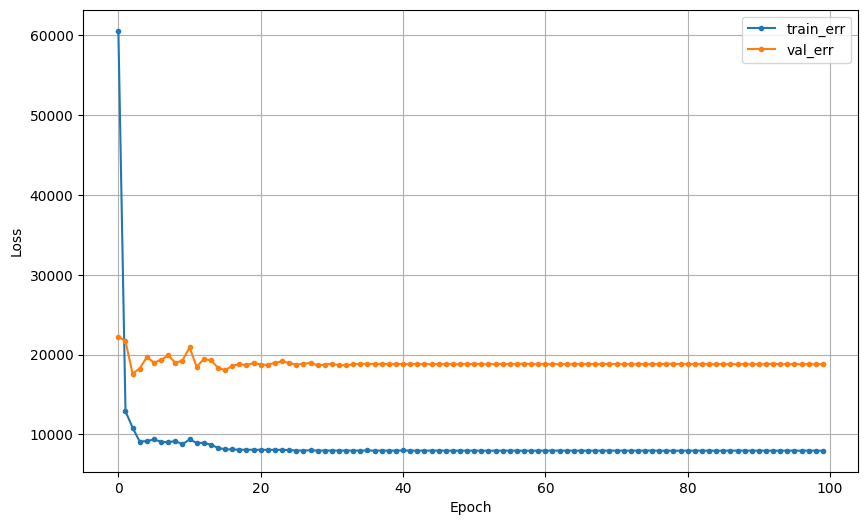

In [145]:
dl_history_plot(train_loss_list, test_loss_list)

In [146]:
X_test_s = torch.FloatTensor(X_test_s)
y_test_s = torch.FloatTensor(y_test_s).unsqueeze(-1)

In [147]:
pred = best_model(X_test_s)

In [148]:
pred = pred.detach().cpu().numpy()

In [149]:
from sklearn.metrics import * 

def RUL_metric(y_valid, y_pred, threshold=10):

    error = y_valid.reshape(-1) - y_pred.reshape(-1)
    per = np.where(error<=threshold, 1, 0)
    
    return sum(per) / len(per)

print(f'RMSE : {mean_squared_error(y_test_s, pred, squared=False)}')
print(f'MAE  : {mean_absolute_error(y_test_s, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_test_s, pred)}')
print(f'R2 : {r2_score(y_test_s, pred)}')
print(f'RUL_metric : {RUL_metric(y_test_s, pred, threshold=100)}')

RMSE : 156.9910125732422
MAE  : 94.30843353271484
MAPE : 0.4231770634651184
R2 : 0.6827826427736399
RUL_metric : 0.7320044296788483
